In [1]:
from src import *

## Description

We visualize joints plots fo 1st and 2nd eigenvectors of affinity matrices (i.e Gradients) and visualize their projection on cortical sufaces. 

GOAL: Joint plot 1st and 2nd connectivity gradients to visualize general topology and unimodal/transmodal distributions during rest and movie watching.

## Table of Contents
- [Single Video Processing](#single)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces
    - Per subject computed gradient generating


- [All Video Processing](#all)
    - Functional Connectivity Matrix and Gradient Computation
    - Joint Plot 1st and 2nd Gradient
    - Visualization of Gradients on Cortical Surfaces

In [2]:
mri_path = "./data/fmri_compiled/"
print(os.listdir(mri_path))

movie_name   = os.listdir(mri_path)[0]
mri_df       = pd.read_csv(mri_path + movie_name)

['TheSecretNumber_compiled.csv', 'ToClaireFromSonny_compiled.csv', 'Chatter_compiled.csv', 'LessonLearned_compiled.csv', 'Payload_compiled.csv', 'AfterTheRain_compiled.csv', 'Superhero_compiled.csv', 'Sintel_compiled.csv', 'TearsOfSteel_compiled.csv', 'BetweenViewing_compiled.csv', 'BigBuckBunny_compiled.csv', 'Rest_compiled.csv', 'YouAgain_compiled.csv', 'Spaceman_compiled.csv', 'FirstBite_compiled.csv']


In [16]:
# trim the washimg time for movies before and after
wash  = 93.9/ TR # duration in seconds for wash is 93.9 sec
onset = 6 / TR # duration of onset is assumed to be 6 sec
film_duration = FILM2DURATION[movie_name.split('_')[0]] # in seconds
duration_film =  int(film_duration/ TR) # in number of TRs
front_pad     = int(wash + onset) + 1

embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

In [49]:
correlation_measure = ConnectivityMeasure(kind='correlation')

subjects = [c for c in mri_df.filename.unique() if '400' in c]
samples_names = []
samples_grad  = []
nbs = 50
for _ in range(nbs):
    samples_names.append(np.random.choice(subjects, 25, replace=False))

for i in tqdm(range(nbs)):
    concat_series = []
    for filename_movie in samples_names[i]:
        movie_series, _ = df_to_timeseries(mri_df, filename_movie)
        movie_series  = movie_series[front_pad : front_pad + duration_film]
        concat_series.append(movie_series)
    concat_series = np.concatenate(concat_series)

    fc_movie = correlation_measure.fit_transform([concat_series])[0]

    g = GradientMaps(n_components=nb_comp, approach=embedding, kernel=aff_kernel, random_state=rs)
    g.fit(fc_movie)
    samples_grad.append(g.gradients_)

  0%|          | 0/50 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [30]:
from brainspace.gradient import procrustes_alignment
aligned,ref = procrustes_alignment(samples_grad, return_reference=True, n_iter=100)
aligned = np.asarray(aligned)
circle_confusion = aligned.std(axis=0)[:,[0,1]]

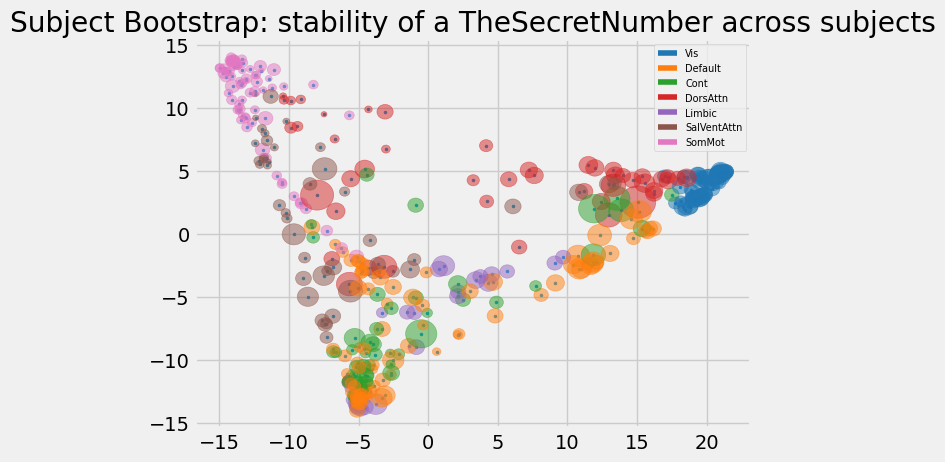

In [76]:
partial_region = load('./resources/region400yeo7.pkl')
colors = {'Vis':'tab:blue', 'Default':'tab:orange', 'Cont':'tab:green', 'DorsAttn':'tab:red', 'Limbic':'tab:purple', 'SalVentAttn': 'tab:brown', 'SomMot': 'tab:pink'}


figure, axes = plt.subplots()

axes.scatter(ref[:,0], ref[:,1], s=4)

for i in range(len(circle_confusion)):
    c = partial_region[i]
    pts = circle_confusion[i]
    m   = np.mean(pts)
    cc  = plt.Circle((ref[i][0],ref[i][1]), m ,alpha=0.5, color=colors[c])
    axes.add_artist(cc)

axes.set_title("Subject Bootstrap: stability of a {} across subjects".format(movie_name.split('_')[0]))

C = list(colors.values())
labels = list(colors.keys())
dummies = [axes.plot([], [], ls='-', c=c)[0] for c in C]
axes.legend(dummies, labels, loc=1, prop={'size':7})
plt.show()